##Cell 1、2: 上傳檔案

In [33]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 設定繪圖風格
sns.set(style="whitegrid")

# 定義檔案名稱 (請確認這跟你上傳到 GitHub 的檔名一致)
netflix_file = 'netflix_titles.csv'
imdb_file = 'Netflix_IMDB_Scores.csv'

# 資料讀取邏輯
# 1. 先嘗試直接讀取
if os.path.exists(netflix_file) and os.path.exists(imdb_file):
    print("偵測到資料檔.")
    df = pd.read_csv(netflix_file)
    df_imdb = pd.read_csv(imdb_file)

else:
    # 2. 如果找不到檔案才跳出上傳按鈕
    print("找不到資料檔")
    from google.colab import files
    uploaded = files.upload()

    df = pd.read_csv(netflix_file)
    df_imdb = pd.read_csv(imdb_file)

print(f"資料讀取完成！")
print(f"Netflix 資料筆數: {df.shape}")
print(f"IMDb 資料筆數: {df_imdb.shape}")

偵測到資料檔.
資料讀取完成！
Netflix 資料筆數: (8807, 12)
IMDb 資料筆數: (5283, 11)


# Cell 3: 重新載入乾淨資料並合併

In [26]:

import numpy as np
import pandas as pd
import io
from sklearn.preprocessing import MultiLabelBinarizer


try:
    df = pd.read_csv('netflix_titles.csv')
except:

    print("重新讀取原始檔...")

    if 'imdb_score' in df.columns:
        df = df.drop(columns=['imdb_score'])

#1. 設定新檔案的欄位名稱
imdb_title_col = 'title'
imdb_score_col = 'imdb_score'

print(f"正在合併資料...")

#2. 準備合併
df['title_clean'] = df['title'].str.strip().str.lower()
df_imdb['title_clean'] = df_imdb[imdb_title_col].str.strip().str.lower()

# 進行合併
merged_df = pd.merge(df, df_imdb[['title_clean', imdb_score_col]], on='title_clean', how='inner')

# 如合併後出現了 _x, _y 的情況，我們強制修正
if 'imdb_score_y' in merged_df.columns:
    merged_df.rename(columns={'imdb_score_y': 'imdb_score'}, inplace=True)
elif imdb_score_col not in merged_df.columns:
    # 如真的發生欄位改名會在這裡抓回來
    pass

print(f"合併成功！擁有真實分數的資料筆數：{len(merged_df)}")

#3. 定義目標變數
merged_df['is_hit'] = merged_df['imdb_score'].apply(lambda x: 1 if x >= 7.0 else 0)

#4. 處理時長
def process_duration(x):
    if pd.isna(x): return 0
    if isinstance(x, str):
        if 'min' in x: return int(x.split(' ')[0])
        if 'Season' in x: return int(x.split(' ')[0]) * 10
    return 0
merged_df['duration_num'] = merged_df['duration'].apply(process_duration)

#5. 處理類型
merged_df['listed_in'] = merged_df['listed_in'].fillna('')
merged_df['genre_list'] = merged_df['listed_in'].apply(lambda x: [i.strip() for i in x.split(',')])

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(merged_df['genre_list'])
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_, index=merged_df.index)

#6. 準備訓練資料
X = pd.concat([merged_df[['duration_num', 'release_year']], genre_df], axis=1)
y = merged_df['is_hit']
X = X.fillna(0)

print("------------------------------------------------")
print("特徵工程全部完成！")
print(f"前 3 筆預覽：\n{merged_df[['title', 'imdb_score']].head(3)}")

正在合併資料...
合併成功！擁有真實分數的資料筆數：3960
------------------------------------------------
特徵工程全部完成！
前 3 筆預覽：
                   title  imdb_score
0   Dick Johnson Is Dead         7.4
1              Ganglands         7.0
2  Jailbirds New Orleans         6.6


In [22]:
#偵錯模式
print(df_imdb.columns.tolist())

['index', 'id', 'title', 'type', 'description', 'release_year', 'age_certification', 'runtime', 'imdb_id', 'imdb_score', 'imdb_votes']


# Cell 4: 訓練 Random Forest 模型

In [27]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. 切分訓練集 (80%) 與測試集 (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 建立模型
print("正在訓練模型")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3. 預測
y_pred = rf_model.predict(X_test)

print("訓練完成")
print("模型準確度")
print(classification_report(y_test, y_pred))

正在訓練模型
訓練完成
模型準確度
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       483
           1       0.61      0.58      0.59       309

    accuracy                           0.69       792
   macro avg       0.67      0.67      0.67       792
weighted avg       0.69      0.69      0.69       792



# Cell 5: 視覺化

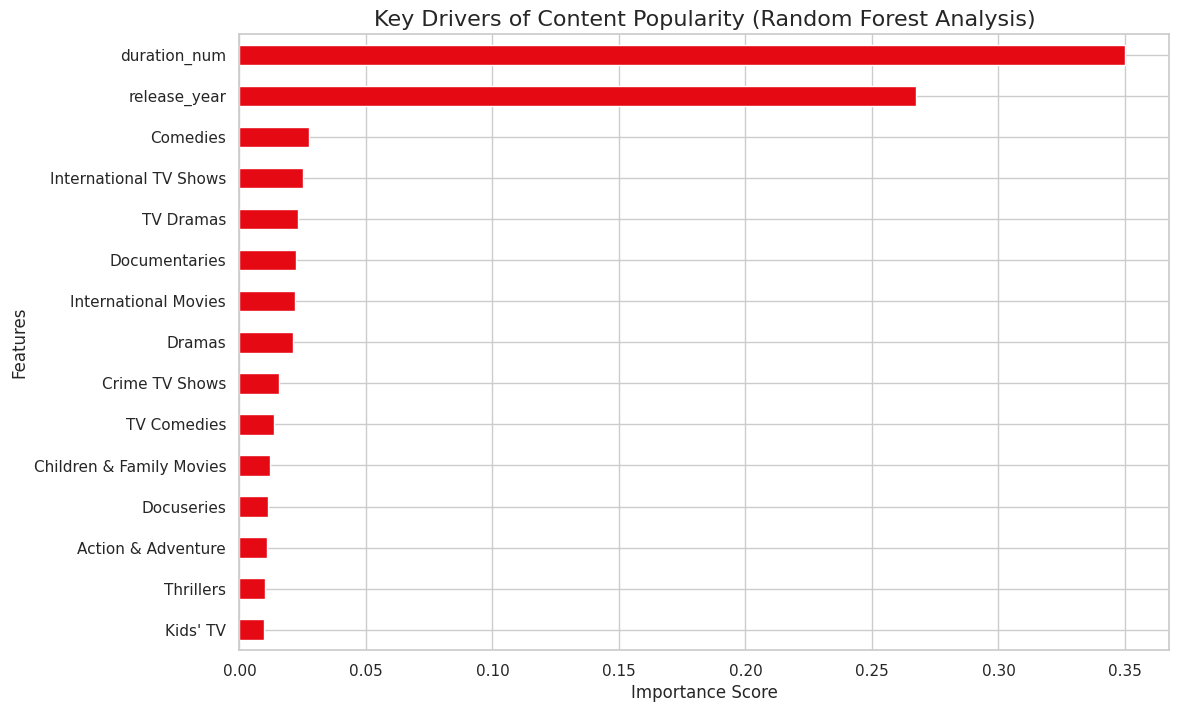

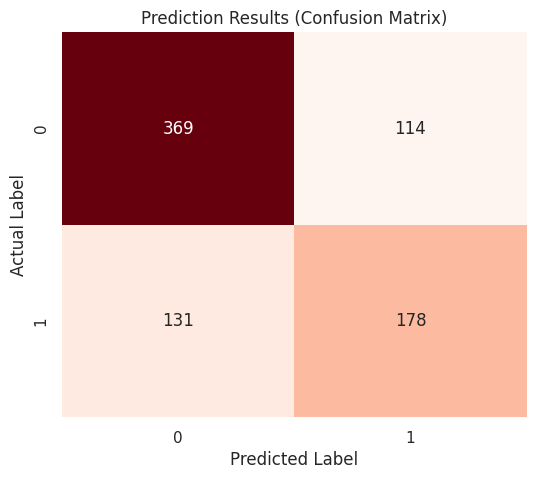

In [28]:

import matplotlib.pyplot as plt
import seaborn as sns

# 設定畫圖風格
sns.set(style="whitegrid")

# 1. 抓出特徵重要性
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# 2. 畫出前 15 名最重要的特徵
plt.figure(figsize=(12, 8))
top_15_features = feature_importances.nlargest(15)
top_15_features.sort_values().plot(kind='barh', color='#E50914') # Netflix Red

plt.title('Key Drivers of Content Popularity (Random Forest Analysis)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# 3. (選用) 混淆矩陣 - 看看我們預測對了多少
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Prediction Results (Confusion Matrix)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Cell 6: 只看「類型」的排名 (排除時長和年份)

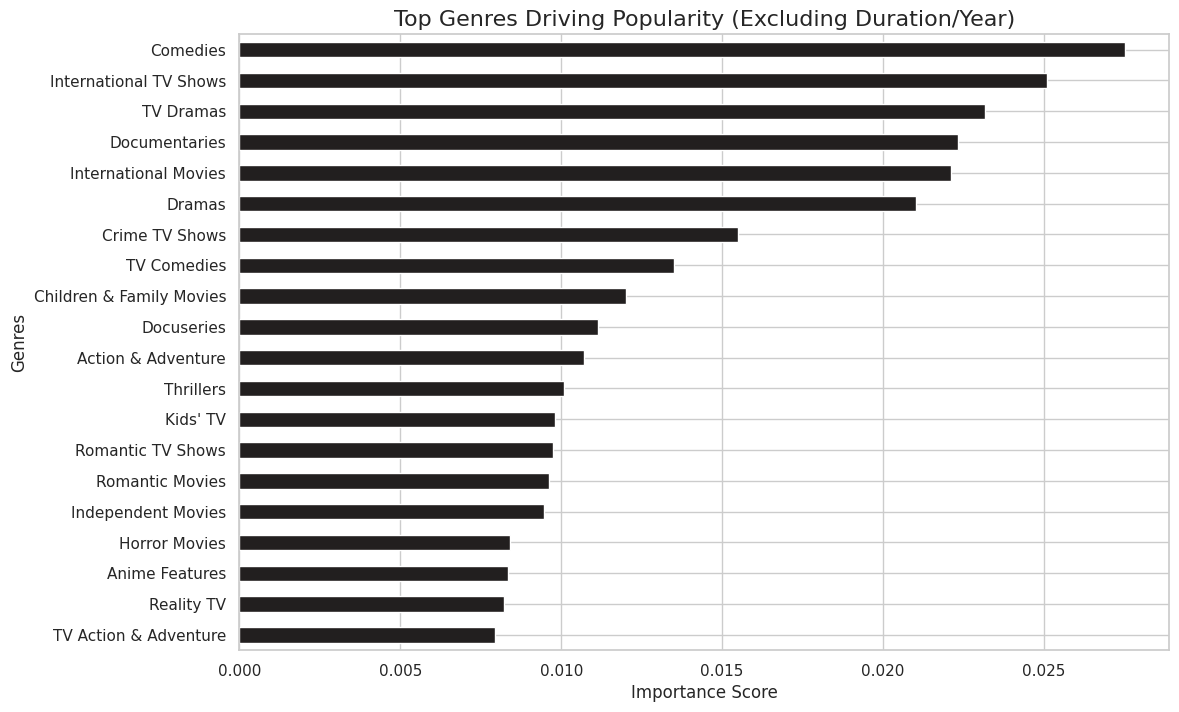

In [29]:


# 1. 找出所有類型的欄位名稱 (除了 duration_num 和 release_year 以外的)
genre_cols = [col for col in X.columns if col not in ['duration_num', 'release_year']]

# 2. 只抓特徵重要性
genre_importances = pd.Series(rf_model.feature_importances_, index=X.columns)[genre_cols]

# 3. 畫圖
plt.figure(figsize=(12, 8))

top_20_genres = genre_importances.nlargest(20)
top_20_genres.sort_values().plot(kind='barh', color='#221f1f') # Netflix Black

plt.title('Top Genres Driving Popularity (Excluding Duration/Year)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Genres')
plt.show()

# Cell 7: 進階特徵工程 - 導演影響力分析 (Target Encoding)

In [30]:


# 1. 計算每個導演的「平均作品分數」
director_exploded = merged_df.assign(director=merged_df['director'].str.split(', ')).explode('director')

# 算平均分
director_stats = director_exploded.groupby('director')['imdb_score'].mean().reset_index()
director_stats.rename(columns={'imdb_score': 'director_avg_score'}, inplace=True)

# 2. 把這個導演分數合併回原本的資料表
merged_df_exploded = merged_df.assign(director_split=merged_df['director'].str.split(', ')).explode('director_split')
merged_df_with_score = pd.merge(merged_df_exploded, director_stats, left_on='director_split', right_on='director', how='left')

# 針對每一部電影算出它所有導演的平均實力
final_director_score = merged_df_with_score.groupby('title_clean')['director_avg_score'].mean().reset_index()

# 合併回主表
merged_df = pd.merge(merged_df, final_director_score, on='title_clean', how='left')

# 填補沒有導演資料的空值
global_avg = merged_df['imdb_score'].mean()
merged_df['director_avg_score'] = merged_df['director_avg_score'].fillna(global_avg)

# 重新訓練模型 (加入導演特徵)
print("正在將導演影響力加入模型訓練...")

# 更新特徵矩陣 X
X_advanced = pd.concat([merged_df[['duration_num', 'release_year', 'director_avg_score']], genre_df], axis=1)
y_advanced = merged_df['is_hit']
X_advanced = X_advanced.fillna(0)

# 重新切分與訓練
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_advanced, y_advanced, test_size=0.2, random_state=42)
rf_model_adv = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_adv.fit(X_train_adv, y_train_adv)

print("新模型訓練完成")
print("特徵重要性排名 (前 5 名):")
feature_importances_adv = pd.Series(rf_model_adv.feature_importances_, index=X_advanced.columns)
print(feature_importances_adv.nlargest(5))

正在將導演影響力加入模型訓練...
新模型訓練完成
特徵重要性排名 (前 5 名):
director_avg_score        0.415168
duration_num              0.158218
release_year              0.152569
International TV Shows    0.021650
TV Dramas                 0.021398
dtype: float64


# Cell 8: 決策樹可視化 (Visualizing the Logic)

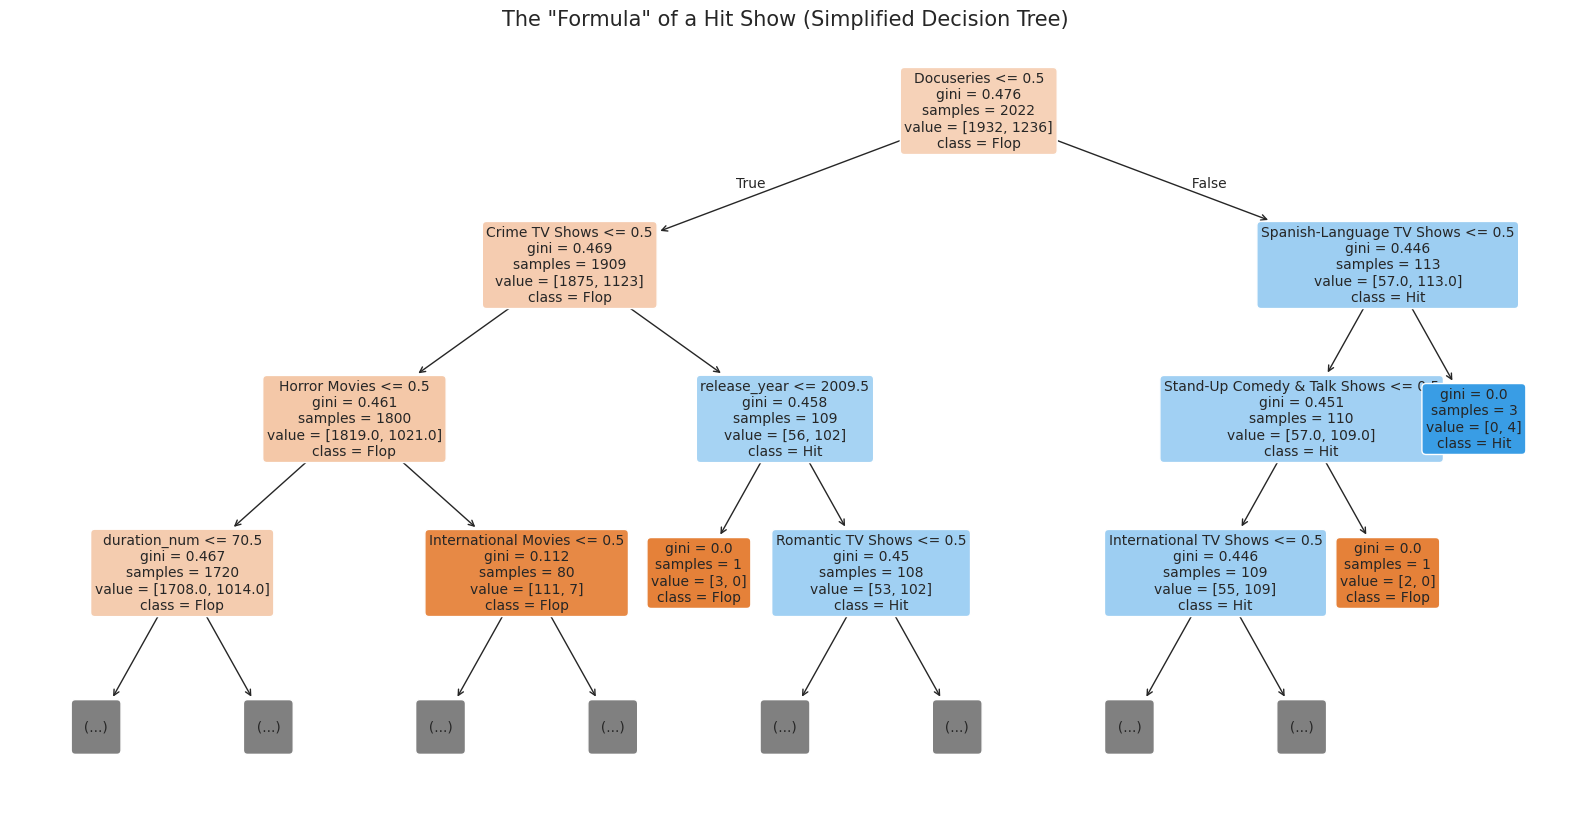

In [31]:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 從隨機森林中隨便挑一棵樹出來
one_tree = rf_model_adv.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(one_tree,
          feature_names=X_advanced.columns,
          class_names=['Flop', 'Hit'],
          filled=True,
          rounded=True,
          max_depth=3,     # 只畫出前3層不然樹太深看不清楚
          fontsize=10)

plt.title('The "Formula" of a Hit Show (Simplified Decision Tree)', fontsize=15)
plt.show()

# Cell 9: 熱門 vs 冷門內容的基因分析 (雷達圖)

In [32]:

import pandas as pd
import plotly.graph_objects as go

# 我們把類型表和是否熱門暫時拼在一起
plot_data = pd.concat([genre_df, merged_df['is_hit']], axis=1)

# 1. 算出熱門片和普通片在各個類型的平均出現率
# 注意：現在是從 plot_data 裡面抓資料，而不是 merged_df
hit_genres = plot_data[plot_data['is_hit'] == 1][mlb.classes_].mean()
flop_genres = plot_data[plot_data['is_hit'] == 0][mlb.classes_].mean()

# 為了圖表清晰，我們只取差異最大的前8個類型
# 算出差異
diff = (hit_genres - flop_genres).abs().sort_values(ascending=False).head(8)
selected_genres = diff.index.tolist()

print(f"差異最大的前 8 個類型：{selected_genres}")

# 2. 畫雷達圖
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=hit_genres[selected_genres].values,
      theta=selected_genres,
      fill='toself',
      name='Hit Shows (>7.0)',
      line_color='#E50914' # Netflix Red
))

fig.add_trace(go.Scatterpolar(
      r=flop_genres[selected_genres].values,
      theta=selected_genres,
      fill='toself',
      name='Regular Shows (<7.0)',
      line_color='gray'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, max(hit_genres[selected_genres].max(), flop_genres[selected_genres].max()) + 0.05]
    )),
  title="Content DNA: What distinguishes a Hit from a Flop?",
  showlegend=True
)

fig.show()

差異最大的前 8 個類型：['International Movies', 'International TV Shows', 'Comedies', 'TV Dramas', 'Dramas', 'Crime TV Shows', 'Romantic Movies', 'Docuseries']
